In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
# from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS, get_masking_index
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import *
from hmpai.behaviour.sat2 import read_behavioural_info, SAT2_SPLITS, merge_data
from hmpai.pytorch.mamba import *

In [2]:
# Set base variables
set_global_seed(42)
# data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"]
# data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_low.nc", DATA_PATH / "sat2/stage_data_proba_250hz_high.nc"]
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]

# train_percentage=100 makes test and val 100 as well
# splits = split_participants(data_paths, train_percentage=60)
splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ['event_name', 'participant', 'epochs', 'rt', 'condition']
subset_cond = None # 'speed'|'accuracy'|None
skip_samples = 62 #62
cut_samples = 63 #63
add_negative = True

In [3]:
# Create datasets
norm_fn = norm_mad_zscore
# statistics = {
#     "global_min": -0.00014557216,
#     "global_max": 0.00014740844,
#     "global_mean": -2.277374212336032e-18,
#     "global_std": 3.3968840765876904e-06,
#     "global_median": 3.4879516e-11,
#     "mad_score": 3.2237037e-06,
#     "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
# }
# norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_negative=add_negative,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1] + splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
    add_negative=add_negative,
)

In [4]:
# Load in behavioural data
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader_sat2 = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [5]:
chk_path = Path("../../models/bigbig_jitter.pt")
checkpoint = load_model(chk_path)
model = TestMamba(64, 128, 64, len(labels), 5, False)
# model = TestMamba(64, 128, 19, len(labels), 5, False)
# model = TestMamba(64, 128, 19, 5, 5, False)
# model = TestMamba(64, 128, 64, len(labels), 5, False)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

#### Single Trial

tensor(16268)
{'event_name': 'stim/high/accuracy/right/3', 'participant': 'S5', 'epochs': 2308, 'rt': 0.916, 'condition': 'accuracy'}
FC                     2.0
SAT               accuracy
expdResp             right
contrast                 3
N200                   NaN
trial                 2308
participant             S5
givenResp             left
response                 0
rt              916.992188
prmt            777.343753
mt              139.648435
trialType               SA
EMG_sequence            IR
Name: 9410, dtype: object
RT/masking index ratio: 4.021895408630371


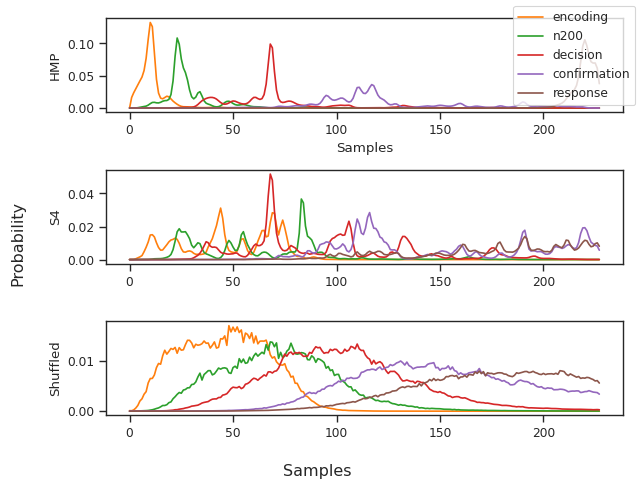

tensor(11934)
{'event_name': 'stim/low/accuracy/left/3', 'participant': 'S3', 'epochs': 2414, 'rt': 0.76, 'condition': 'accuracy'}
FC                     1.0
SAT               accuracy
expdResp              left
contrast                 3
N200                   NaN
trial                 2414
participant             S3
givenResp             left
response                 1
rt              759.765625
prmt            691.406247
mt               68.359378
trialType               SA
EMG_sequence            CR
Name: 26089, dtype: object
RT/masking index ratio: 4.019923686981201


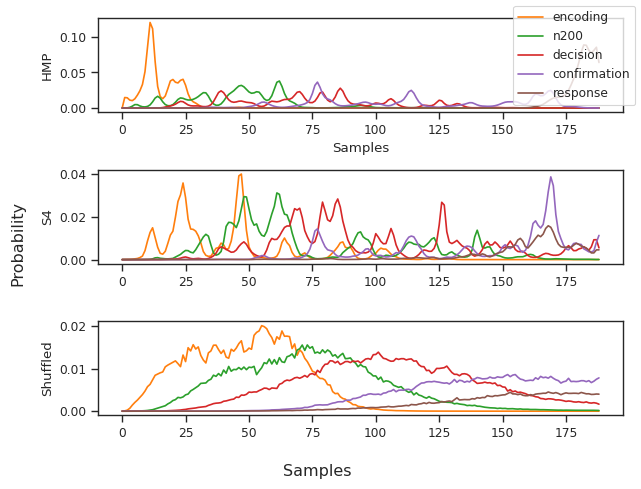

tensor(5931)
{'event_name': 'stim/high/speed/right/3', 'participant': 'S15', 'epochs': 1257, 'rt': 0.454, 'condition': 'speed'}
FC                     2.0
SAT                  speed
expdResp             right
contrast                 3
N200                 168.0
trial                 1257
participant            S15
givenResp             left
response                 0
rt              454.101562
prmt            318.359375
mt              135.742188
trialType               SA
EMG_sequence            IR
Name: 13207, dtype: object
RT/masking index ratio: 4.0185980796813965


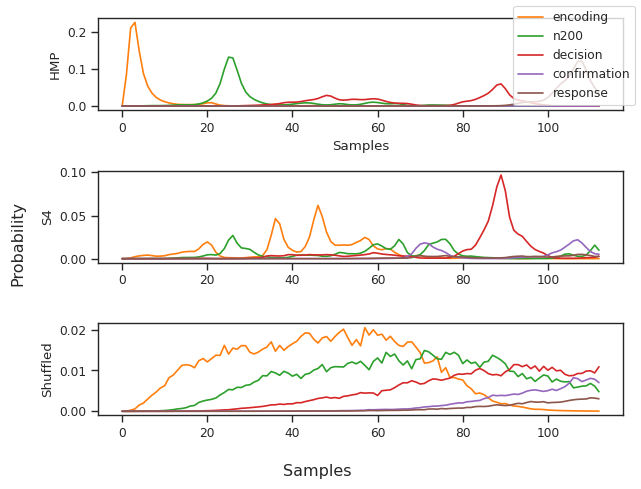

tensor(4216)
{'event_name': 'stim/high/accuracy/left/2', 'participant': 'S11', 'epochs': 1944, 'rt': 1.084, 'condition': 'accuracy'}
FC                      1.0
SAT                accuracy
expdResp               left
contrast                  2
N200                  157.0
trial                  1552
participant             S11
givenResp              left
response                  1
rt              1083.984375
prmt             1042.96875
mt                41.015625
trialType                SA
EMG_sequence             CR
Name: 38427, dtype: object
RT/masking index ratio: 4.014756679534912


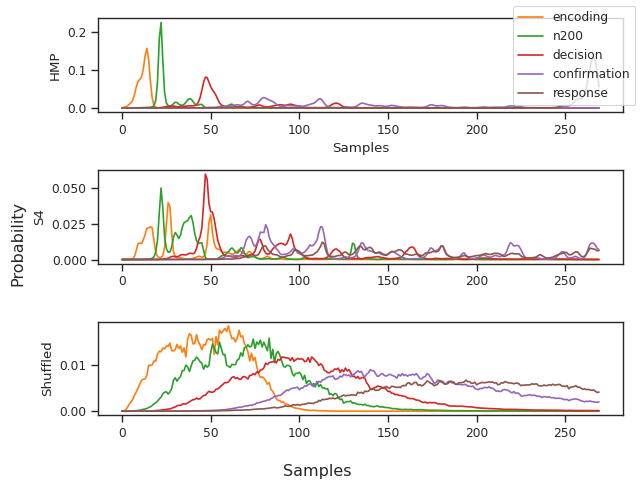

tensor(4725)
{'event_name': 'stim/high/speed/right/3', 'participant': 'S15', 'epochs': 48, 'rt': 0.908, 'condition': 'speed'}
FC                     2.0
SAT                  speed
expdResp             right
contrast                 3
N200                 150.0
trial                   19
participant            S15
givenResp             left
response                 0
rt              908.203125
prmt            441.406253
mt              466.796872
trialType               MA
EMG_sequence           IIR
Name: 11977, dtype: object
RT/masking index ratio: 4.0185980796813965


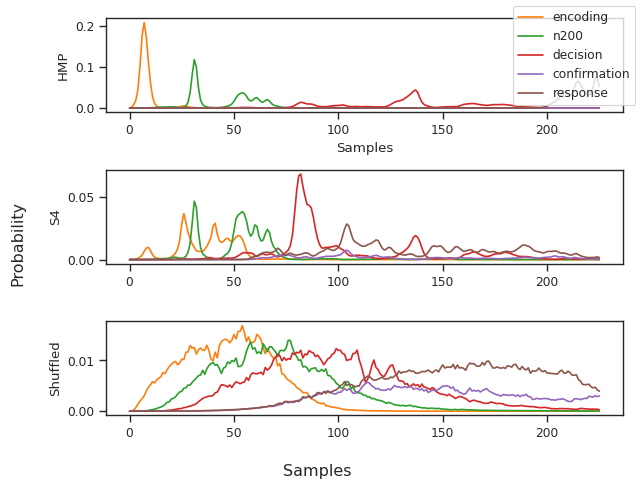

tensor(9421)
{'event_name': 'stim/high/accuracy/right/3', 'participant': 'S17', 'epochs': 2338, 'rt': 0.722, 'condition': 'accuracy'}
FC                     2.0
SAT               accuracy
expdResp             right
contrast                 3
N200                 208.0
trial                 2338
participant            S17
givenResp             left
response                 0
rt              721.679688
prmt            519.531247
mt               202.14844
trialType               SA
EMG_sequence            IR
Name: 19072, dtype: object
RT/masking index ratio: 4.0317301750183105


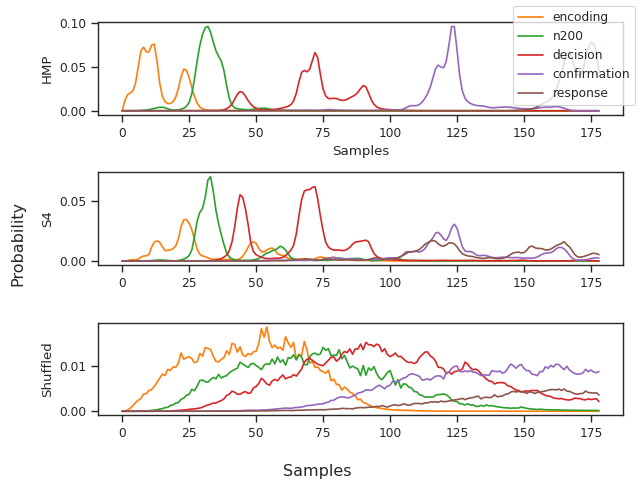

tensor(554)
{'event_name': 'stim/high/accuracy/left/1', 'participant': 'S10', 'epochs': 562, 'rt': 1.028, 'condition': 'accuracy'}
FC                      2.0
SAT                accuracy
expdResp               left
contrast                  1
N200                  189.0
trial                   562
participant             S10
givenResp              left
response                  1
rt              1029.296875
prmt             798.828125
mt                230.46875
trialType                SA
EMG_sequence             CR
Name: 542, dtype: object
RT/masking index ratio: 4.02069091796875


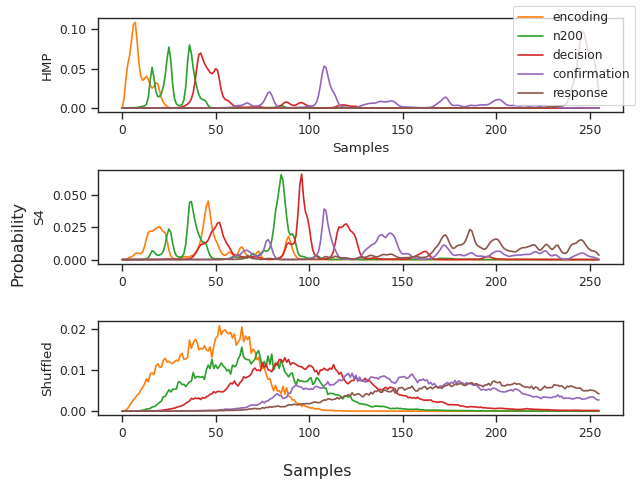

tensor(14853)
{'event_name': 'stim/low/speed/left/3', 'participant': 'S5', 'epochs': 886, 'rt': 0.416, 'condition': 'speed'}
FC                     1.0
SAT                  speed
expdResp              left
contrast                 3
N200                 245.0
trial                  886
participant             S5
givenResp             left
response                 1
rt              416.015625
prmt             375.97656
mt               40.039065
trialType               SA
EMG_sequence            CR
Name: 8019, dtype: object
RT/masking index ratio: 4.038986682891846


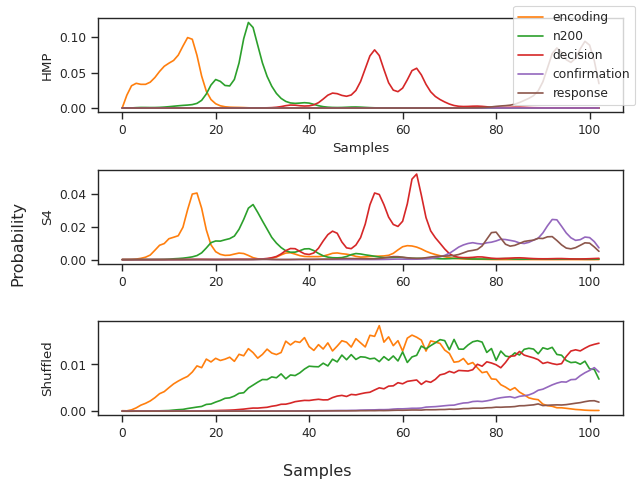

tensor(8303)
{'event_name': 'stim/high/accuracy/right/1', 'participant': 'S17', 'epochs': 1212, 'rt': 0.712, 'condition': 'accuracy'}
FC                     2.0
SAT               accuracy
expdResp             right
contrast                 1
N200                 196.0
trial                 1212
participant            S17
givenResp            right
response                 1
rt              711.914062
prmt            595.703125
mt              116.210938
trialType               SA
EMG_sequence            CR
Name: 17976, dtype: object
RT/masking index ratio: 4.02211332321167


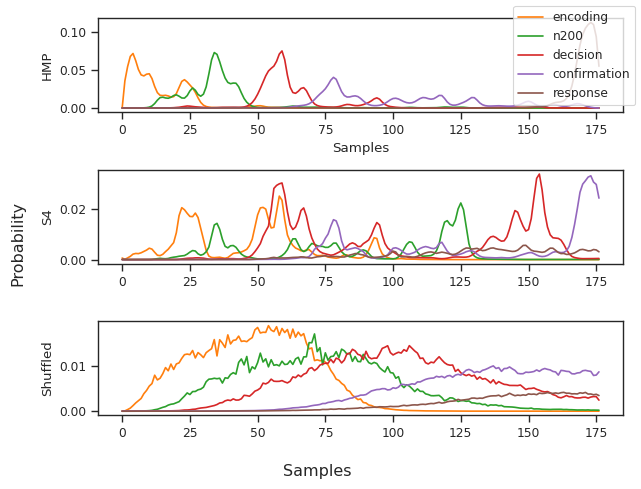

tensor(20568)
{'event_name': 'stim/high/speed/right/2', 'participant': 'S8', 'epochs': 1975, 'rt': 0.606, 'condition': 'speed'}
FC                     2.0
SAT                  speed
expdResp             right
contrast                 2
N200                   NaN
trial                 1975
participant             S8
givenResp            right
response                 1
rt              607.421875
prmt             452.14844
mt              155.273435
trialType               SA
EMG_sequence            CR
Name: 30397, dtype: object
RT/masking index ratio: 4.022661209106445


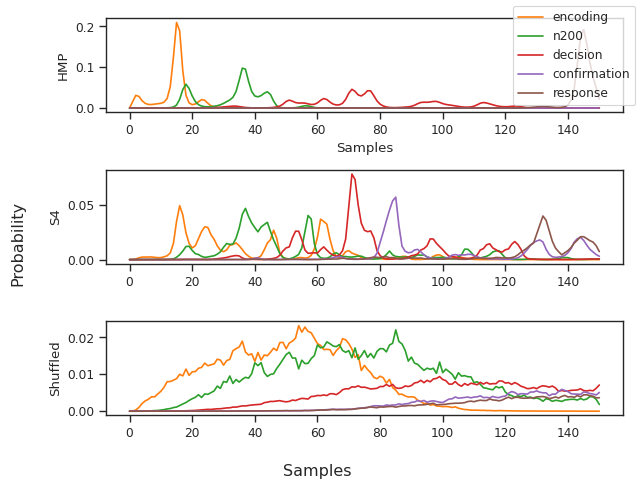

In [6]:
for i in torch.randint(len(test_data), (10,)):
    print(i)
    display_trial(model, test_data, behaviour_sat2, i, labels)

#### Condition level

In [8]:
data = predict_with_auc(model, test_loader_sat2, info_to_keep, labels)

data = merge_data(data, behaviour_sat2)

/workspace/hmp-ai/src/hmpai/visualization.py:1324: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.histplot(data, x='rt_samples', element=element, ax=ax[0], bins=bins, hue='SAT', palette=sns.color_palette()[1:], legend=False)
/workspace/hmp-ai/src/hmpai/visualization.py:1325: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.histplot(data, x=x_col, element=element, ax=ax[1], bins=bins, hue='SAT', palette=sns.color_palette()[1:], legend=False)
/workspace/hmp-ai/src/hmpai/visualization.py:1326: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.histplot(data, x='ratio', element=element, ax=ax[2], bins=bins, hue='SAT', palette=sns.color_palette()[1:])


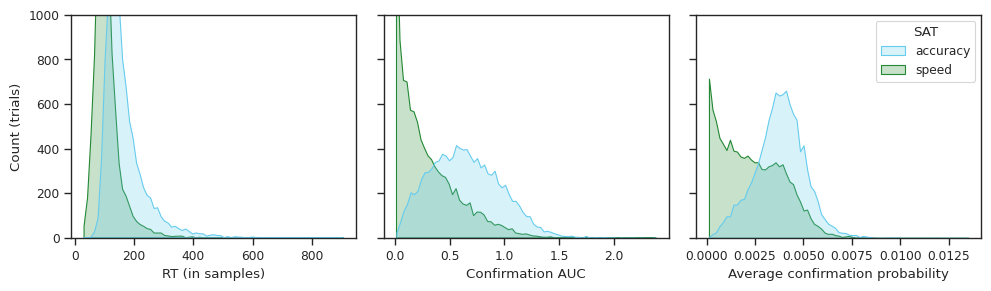

In [9]:
plot_distributions(data, 'confirmation')

encoding


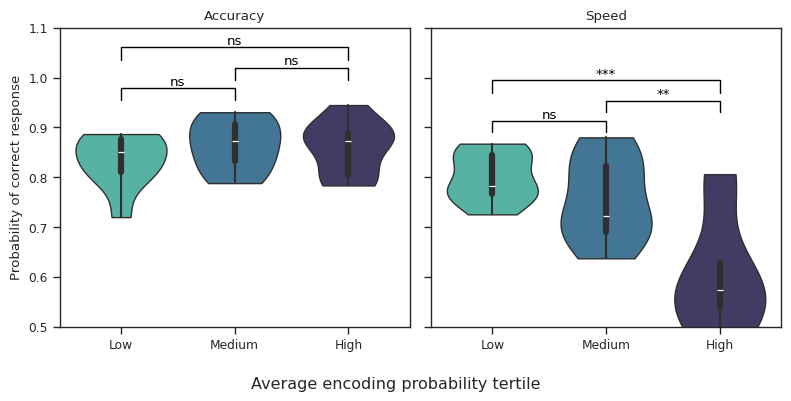

n200


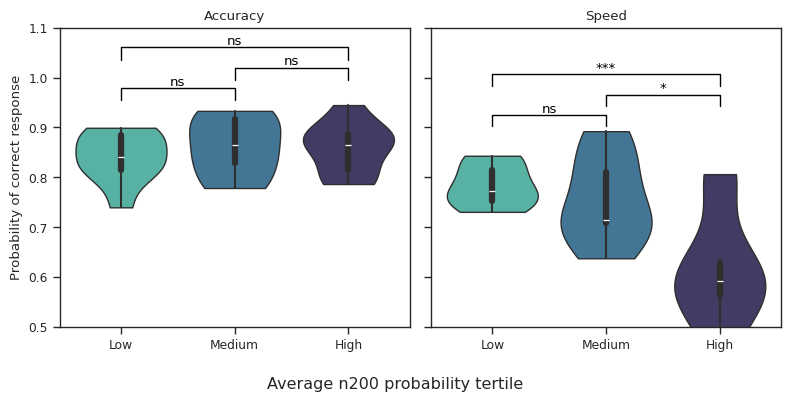

decision


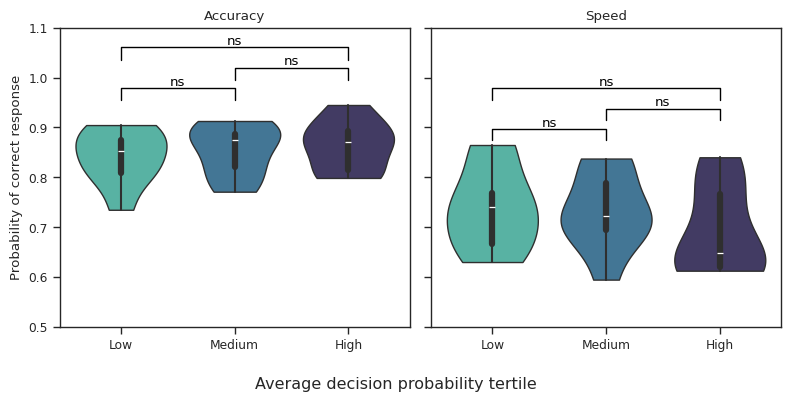

confirmation


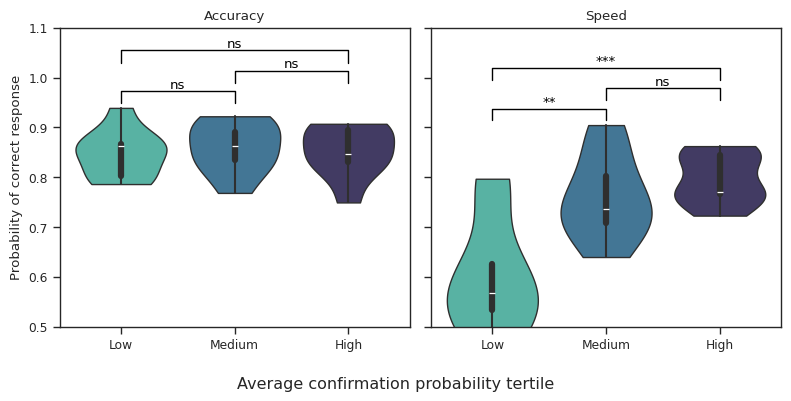

response


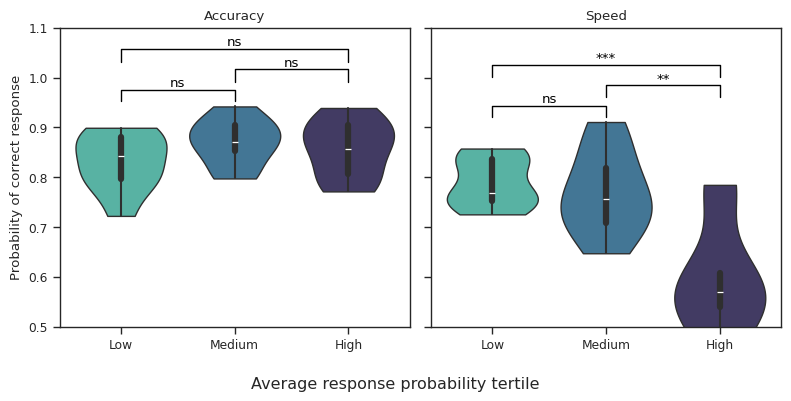

In [10]:
for label in labels[1:]:
    print(label)
    plot_tertile_split(data, f'{label}_ratio', ['accuracy', 'speed'], calc_tertile_over_condition=False, normalize='time')

#### Performance (cumulative)

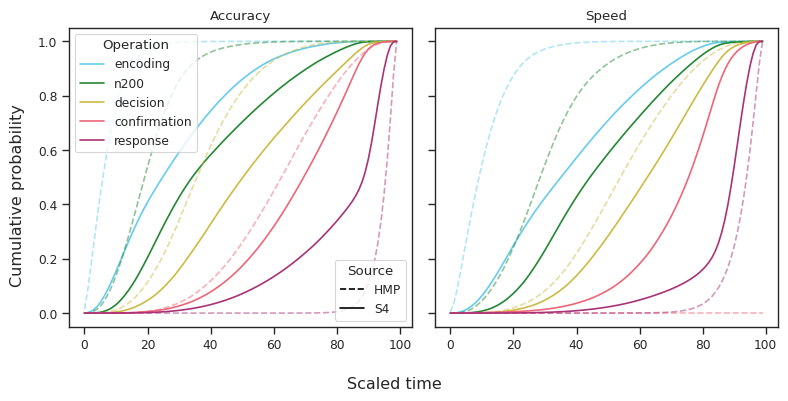

In [7]:
plot_cumulative(model, test_loader_sat2, labels)

#### Performance (density)

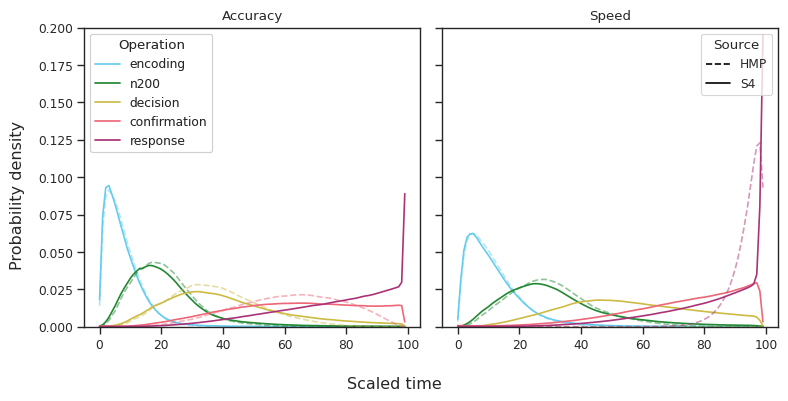

In [ ]:
plot_density(model, test_loader_sat2, labels)

#### Performance (Peak timing)

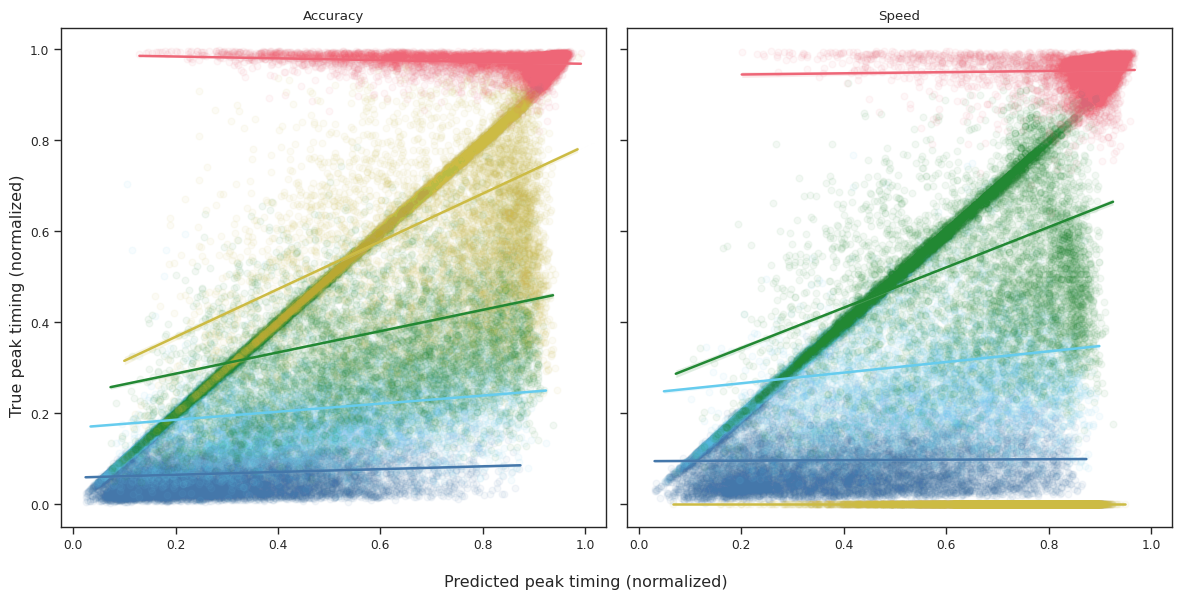

In [8]:
def plot_peak_timing(model, loader, labels):
    output = []
    torch.cuda.empty_cache()
    set_seaborn_style()
    batches = 0
    with torch.no_grad():
        for batch in loader:
            info = batch[2][0]  # Contains RT

            pred = model(batch[0].to(DEVICE))
            pred = torch.nn.Softmax(dim=2)(pred).to("cpu")

            true = batch[1]

            lengths = get_masking_indices(batch[0])

            pred_peaks = pred[..., 1:].argmax(dim=1).float()
            true_peaks = true[..., 1:].argmax(dim=1).float()

            pred_peaks /= lengths.unsqueeze(1)
            true_peaks /= lengths.unsqueeze(1)
            data = {"condition": info["condition"]}
            for i, label in enumerate(labels):
                if i == 0:
                    continue
                label_pred_peaks = pred_peaks[:, i - 1]
                label_true_peaks = true_peaks[:, i - 1]
                data[f"{label}_pred"] = label_pred_peaks
                data[f"{label}_true"] = label_true_peaks
            output.append(data)
            batches += 1
            # if batches > 10:
            #     break
    df = pd.concat([pd.DataFrame(data) for data in output])
    # print(df)
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
    for label in labels:
        if label == "negative":
            continue
        # sns.scatterplot(
        #     data=df[df["condition"] == "accuracy"],
        #     x=f"{label}_pred",
        #     y=f"{label}_true",
        #     alpha=0.7,
        #     ax=ax[0],
        # )

        # sns.scatterplot(
        #     data=df[df["condition"] == "speed"],
        #     x=f"{label}_pred",
        #     y=f"{label}_true",
        #     alpha=0.7,
        #     ax=ax[1],
        # )
        sns.regplot(
            data=df[df["condition"] == "accuracy"],
            x=f"{label}_pred",
            y=f"{label}_true",
            # alpha=0.7,
            ax=ax[0],
            scatter_kws={'alpha': 0.05},
        )

        sns.regplot(
            data=df[df["condition"] == "speed"],
            x=f"{label}_pred",
            y=f"{label}_true",
            # alpha=0.7,
            ax=ax[1],
            scatter_kws={'alpha': 0.05},
        )
        ax[0].set_title("Accuracy")
        ax[1].set_title("Speed")
        ax[0].set_xlabel("")
        ax[1].set_xlabel("")
        ax[0].set_ylabel("")
        ax[1].set_ylabel("")

        fig.supxlabel("Predicted peak timing (normalized)")
        fig.supylabel("True peak timing (normalized)")
    plt.tight_layout()
    plt.show()

plot_peak_timing(model, test_loader_sat2, labels)

#### EMG Sequence

In [17]:
data = predict_with_auc(model, test_loader_sat2, info_to_keep, labels)
data = merge_data(data, behaviour_sat2)

In [32]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def plot_emg_sequence_combined(data, n):
    set_seaborn_style()

    # Combine EMG_sequence groups
    group_mapping = {
        "IR": "IR/CR",
        "CR": "IR/CR",
        "ICR": "ICR/CIR",
        "CIR": "ICR/CIR",
        "CCR": "CCR/IIR",
        "IIR": "CCR/IIR",
    }
    data["EMG_group"] = data["EMG_sequence"].map(group_mapping)

    # Filter based on occurrences
    filtered_data = data[
        data["EMG_group"].isin(
            data["EMG_group"].value_counts()[data["EMG_group"].value_counts() > n].index
        )
    ].copy()
    print(filtered_data["EMG_group"].value_counts())
    # Calculate ratio
    filtered_data["ratio"] = filtered_data["confirmation_auc"] / (
        filtered_data["rt_x"] * 250
    )

    # Compute sorted categories
    sorted_categories = (
        filtered_data.groupby("EMG_group")["ratio"].median().sort_values().index
    )

    ir_cr = filtered_data[filtered_data["EMG_group"] == "IR/CR"]["ratio"]
    icr_cir = filtered_data[filtered_data["EMG_group"] == "ICR/CIR"]["ratio"]
    ccr_iir = filtered_data[filtered_data["EMG_group"] == "CCR/IIR"]["ratio"]

    # p_1 = ttest_ind(ir_cr, icr_cir, equal_var=False)
    # p_2 = ttest_ind(ir_cr, ccr_iir, equal_var=False)
    # p_3 = ttest_ind(icr_cir, ccr_iir, equal_var=False)
    p_1 = mannwhitneyu(ir_cr, icr_cir)
    p_2 = mannwhitneyu(ir_cr, ccr_iir)
    p_3 = mannwhitneyu(icr_cir, ccr_iir)
    print(p_1, p_2, p_3)


    # Create the violin plot
    fig = plt.figure(figsize=(8, 4))
    sns.violinplot(
        x="EMG_group", y="ratio", data=filtered_data, order=sorted_categories, cut=0
    )

    # Add titles and labels
    plt.xlabel("EMG Sequence Groups")
    plt.ylabel("Average Confirmation Probability")
    # plt.legend(title="SAT", loc="upper right")
    add_significance_annotations(p_1.pvalue, 0, 1, ir_cr.max() * 1.1, fig.axes[0])
    add_significance_annotations(p_2.pvalue, 0, 2, ir_cr.max() * 1.25, fig.axes[0])
    add_significance_annotations(p_3.pvalue, 1, 2, ir_cr.max() * 1.4, fig.axes[0])

    # Optional: Rotate x-axis labels for better readability
    # plt.ylim(0, 0.01)
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.savefig("../../img/emg_sequence.svg", transparent=True)
    plt.show()


# Plot for combined groups

In [33]:
group_mapping = {
    "IR": "IR/CR",
    "CR": "IR/CR",
    "ICR": "ICR/CIR",
    "CIR": "ICR/CIR",
    "CCR": "CCR/IIR",
    "IIR": "CCR/IIR",
}
data["EMG_group"] = data["EMG_sequence"].map(group_mapping)

# Filter based on occurrences
filtered_data = data[
    data["EMG_group"].isin(
        data["EMG_group"].value_counts()[data["EMG_group"].value_counts() > 1].index
    )
].copy()
filtered_data["ratio"] = filtered_data["confirmation_auc"] / (
    filtered_data["rt_x"] * 250
)


In [ ]:
filtered_data

,event_name,participant,epochs,rt_x,rt_index_samples,negative_auc,encoding_auc,decision_auc,confirmation_auc,response_auc,...,trial,givenResp,response,rt_y,prmt,mt,trialType,EMG_sequence,EMG_group,ratio
0,low/accuracy/left/1,S15,1604,0.489258,134,461.483948,0.676338,0.758262,0.279115,0.802326,...,1604,right,0,489.257812,413.085938,76.171875,MA,IIR,CCR/IIR,0.002282
1,low/speed/left/3,S10,1999,0.389648,109,461.477356,0.707158,0.739487,0.361478,0.714548,...,1999,left,1,389.648438,356.445315,33.203122,SA,CR,IR/CR,0.003711
2,low/accuracy/right/1,S15,2297,0.435547,121,461.196594,0.850783,0.841540,0.263924,0.847167,...,2297,right,1,435.546875,356.445312,79.101562,SA,CR,IR/CR,0.002424
3,low/speed/left/1,S5,166,0.570312,155,460.844971,0.775117,0.796865,0.653996,0.929051,...,166,left,1,570.312500,497.070312,73.242188,SA,CR,IR/CR,0.004587
4,low/accuracy/left/2,S7,2282,0.514648,141,460.789978,1.195170,0.887217,0.503312,0.624336,...,671,left,1,514.648438,290.039058,224.609380,MA,CCR,CCR/IIR,0.003912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9636,low/speed/left/3,S17,1348,0.292969,85,288.342499,0.729418,0.827153,0.092598,1.008347,...,495,left,1,292.968750,147.460933,145.507817,SA,CR,IR/CR,0.001264
9637,low/speed/right/1,S15,1725,0.437500,121,287.771667,0.905131,1.096856,0.266626,0.959714,...,1725,right,1,437.500000,327.148440,110.351560,SA,CR,IR/CR,0.002438
9638,low/accuracy/left/2,S15,1545,0.359375,102,288.204926,0.924915,0.819796,0.230528,0.819862,...,1545,left,1,359.375000,289.062505,70.312495,SA,CR,IR/CR,0.002566
9639,low/accuracy/right/2,S4,542,0.911133,240,287.536072,0.759687,0.915879,1.013265,0.775080,...,542,right,1,911.132812,811.523438,99.609375,SA,CR,IR/CR,0.004448


In [ ]:
filtered_data["EMG_group"] = pd.Categorical(filtered_data["EMG_group"], categories=["IR/CR", "ICR/CIR", "CCR/IIR"], ordered=True)

In [ ]:
import bambi as bmb
# bmb_model = bmb.Model("ratio ~ EMG_group + (1|SAT)", filtered_data, priors={"EMG_group": bmb.Prior("Normal", mu=0, sigma=10)})
bmb_model = bmb.Model("ratio ~ EMG_group", filtered_data)
results = bmb_model.fit(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, EMG_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


In [ ]:
import arviz as az

print(az.summary(results))

                     mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma               0.001  0.0   0.001    0.001        0.0      0.0   13634.0   
Intercept           0.003  0.0   0.003    0.003        0.0      0.0   12499.0   
EMG_group[ICR/CIR]  0.000  0.0   0.000    0.001        0.0      0.0   13326.0   
EMG_group[CCR/IIR]  0.001  0.0   0.000    0.001        0.0      0.0   14619.0   

                    ess_tail  r_hat  
sigma                 6424.0    1.0  
Intercept             6317.0    1.0  
EMG_group[ICR/CIR]    6208.0    1.0  
EMG_group[CCR/IIR]    6203.0    1.0  


[]

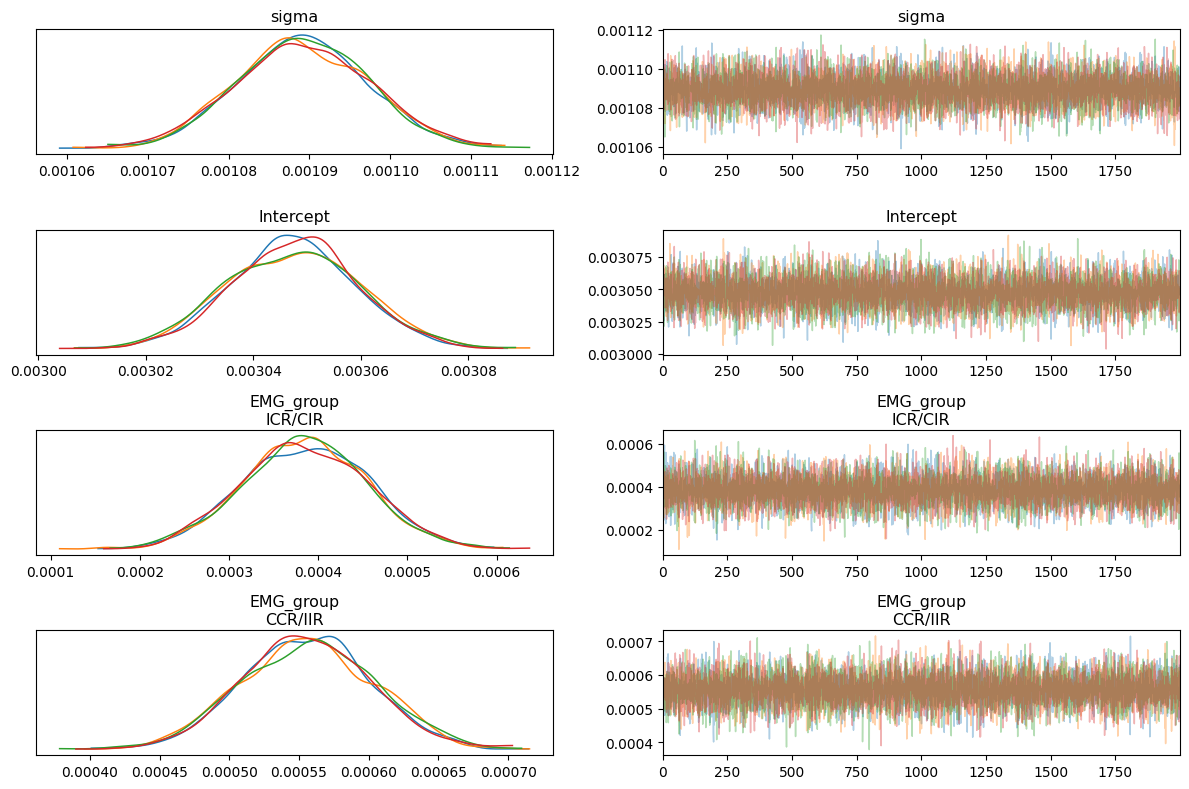

In [ ]:
az.plot_trace(results, compact=False)
plt.tight_layout()
plt.plot()

In [ ]:
# Fit the null model (no group effect)
null_model = bmb.Model("ratio ~ 1", filtered_data)
null_results = null_model.fit(draws=2000, tune=1000, idata_kwargs={"log_likelihood": True})

# Fit the alternative model (with group effect)
alt_results = bmb_model.fit(draws=2000, tune=1000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, EMG_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [ ]:
import arviz as az

# Compare the models
comparison = az.compare({"Null": null_results, "Alternative": alt_results}, method="BB-pseudo-BMA")

# Display the comparison table
print(comparison)

             rank      elpd_loo     p_loo  elpd_diff        weight         se  \
Alternative     0  48055.027083  3.197364   0.000000  1.000000e+00  48.541466   
Null            1  47974.335371  1.531992  80.691712  2.812413e-22  47.896235   

                   dse  warning scale  
Alternative   0.000000    False   log  
Null         12.238068    False   log  


In [ ]:
# Extract log Bayes Factor (ΔLOO)
log_bayes_factor = comparison.loc["Alternative", "p_loo"] - comparison.loc["Null", "p_loo"]
bayes_factor = np.exp(log_bayes_factor)

print(f"Log Bayes Factor: {log_bayes_factor:.2f}")
print(f"Bayes Factor (BF): {bayes_factor:.2f}")

Log Bayes Factor: 1.67
Bayes Factor (BF): 5.29


array([<Axes: title={'center': 'EMG_group\nICR/CIR'}>,
       <Axes: title={'center': 'EMG_group\nCCR/IIR'}>], dtype=object)

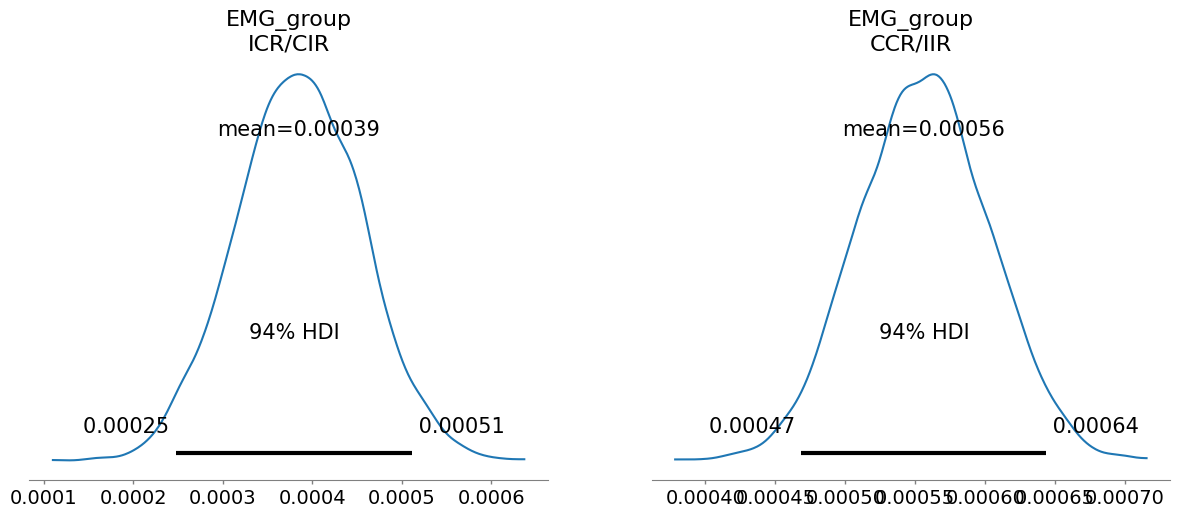

In [ ]:
# Plot posterior distributions for group effects
az.plot_posterior(results, var_names=["EMG_group"])

EMG_group
IR/CR      8667
CCR/IIR     738
ICR/CIR     464
Name: count, dtype: int64
MannwhitneyuResult(statistic=1316407.0, pvalue=3.916699177021065e-36) MannwhitneyuResult(statistic=2395678.5, pvalue=9.018954717480534e-30) MannwhitneyuResult(statistic=187047.0, pvalue=0.006894965631487919)


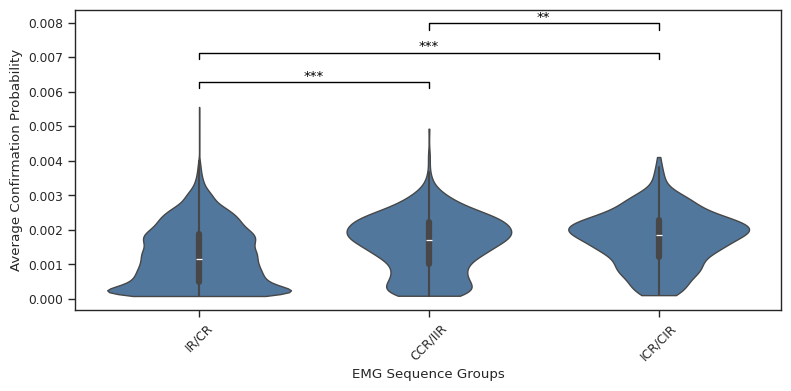

In [34]:
plot_emg_sequence_combined(data[data['SAT'] == 'speed'], 1)

EMG_group
IR/CR      8551
CCR/IIR     909
ICR/CIR     257
Name: count, dtype: int64
MannwhitneyuResult(statistic=1047263.0, pvalue=0.19941956700624086) MannwhitneyuResult(statistic=3855608.0, pvalue=0.6937938276957216) MannwhitneyuResult(statistic=121806.0, pvalue=0.29427334607967026)


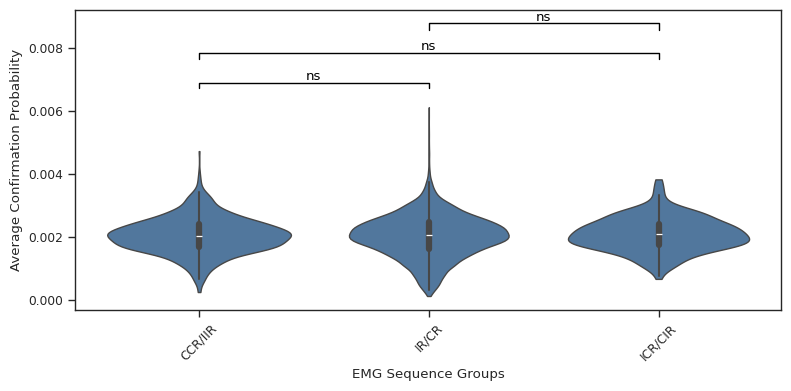

In [35]:
plot_emg_sequence_combined(data[data['SAT'] == 'accuracy'], 1)


EMG_group
IR/CR      17218
CCR/IIR     1647
ICR/CIR      721
Name: count, dtype: int64
MannwhitneyuResult(statistic=5204548.0, pvalue=1.852097346015334e-13) MannwhitneyuResult(statistic=12088961.5, pvalue=4.223600447382504e-23) MannwhitneyuResult(statistic=601844.0, pvalue=0.5967860086596586)


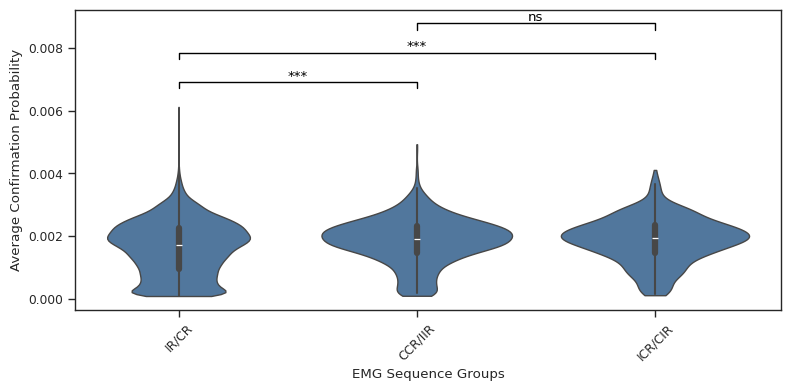

In [36]:
plot_emg_sequence_combined(data, 1)